# Age Classification Model from fMRI 

This project aims to classify individuals as children or adults based on resting-state fMRI signal patterns using a Support Vector Classifier. The dataset includes individuals across a wide age range, from children (ages 3-13) to young adults (ages 18-39).

In [51]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets, maskers, plotting
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Set your data directory
data_dir = './nilearn_data'

# Extract your dataset
datasets_selection = datasets.fetch_development_fmri

data = datasets_selection(data_dir=data_dir,reduce_confounds = False)

In [18]:

# Get the keys

print('Keys:',list(data.keys()))

# Get the number of subjects

print('Number of subjects:', len(data.func))

Keys: ['func', 'confounds', 'phenotypic', 'description']
Number of subjects: 155


### Explore the Target Variable (Y)

In [19]:
# Load the phenotype data

pheno = pd.DataFrame(data.phenotypic)

In [20]:
# INFO

df = pheno

# Display the shape of the data
print("Data Shape:")
print(df.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',df.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_columns = df.columns[df.isnull().any()]
if missing_columns.size > 0:
    missing_values = df[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(155, 6)

Duplicate Values:
( 0 )

Data Types:
object     5
float64    1
dtype: int64

No Missing Values Found


In [21]:
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [22]:
y = pheno['Child_Adult']

print('Number of classes:',y.unique())

Number of classes: ['adult' 'child']


child    122
adult     33
Name: Child_Adult, dtype: int64


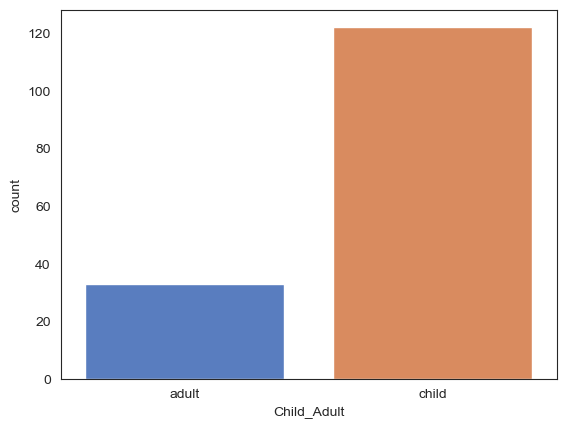

In [23]:
sns.set_style("white")
sns.set_palette("muted")
sns.countplot(x= y)

print(y.value_counts())

### Extract features with nilearn masker


In [53]:
# Load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015(data_dir=data_dir)
atlas_filename = multiscale.scale064


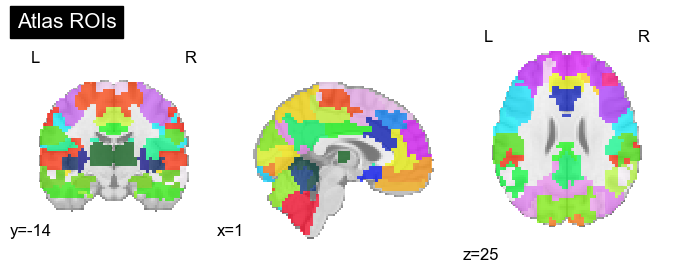

In [52]:
# Visualize Region of Interest
plotting.plot_roi(atlas_filename, draw_cross=False, title='Atlas ROIs');

In [24]:
# Initialize masker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', resampling_target="data",
                           detrend=True, verbose=0)


# Initialize correlation measure
correlation_measure = ConnectivityMeasure(kind='correlation', vectorize=True,
                                         discard_diagonal=True)

Extract fMRI connectivity features from every subject.

In [25]:
all_features = [] # here is where we will put the data (a container)

for i,sub in enumerate(data.func):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub, confounds=data.confounds[i])
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    # add to our container
    all_features.append(correlation_matrix)
    # keep track of status
    print('finished %s of %s'%(i+1,len(data.func)))

finished 1 of 155
finished 2 of 155
finished 3 of 155
finished 4 of 155
finished 5 of 155
finished 6 of 155
finished 7 of 155
finished 8 of 155
finished 9 of 155
finished 10 of 155
finished 11 of 155
finished 12 of 155
finished 13 of 155
finished 14 of 155
finished 15 of 155
finished 16 of 155
finished 17 of 155
finished 18 of 155
finished 19 of 155
finished 20 of 155
finished 21 of 155
finished 22 of 155
finished 23 of 155
finished 24 of 155
finished 25 of 155
finished 26 of 155
finished 27 of 155
finished 28 of 155
finished 29 of 155
finished 30 of 155
finished 31 of 155
finished 32 of 155
finished 33 of 155
finished 34 of 155
finished 35 of 155
finished 36 of 155
finished 37 of 155
finished 38 of 155
finished 39 of 155
finished 40 of 155
finished 41 of 155
finished 42 of 155
finished 43 of 155
finished 44 of 155
finished 45 of 155
finished 46 of 155
finished 47 of 155
finished 48 of 155
finished 49 of 155
finished 50 of 155
finished 51 of 155
finished 52 of 155
finished 53 of 155
fi

In [26]:
# Let's save the data to disk

np.savez_compressed('MAIN_BASC064_subsamp_featuresv2',a = all_features)

In [27]:
# Load the features

feat_file = 'MAIN_BASC064_subsamp_featuresv2.npz'
X_features = np.load(feat_file)['a']

print('Features shape:', X_features.shape)

Features shape: (155, 2016)


Text(0, 0.5, 'subjects')

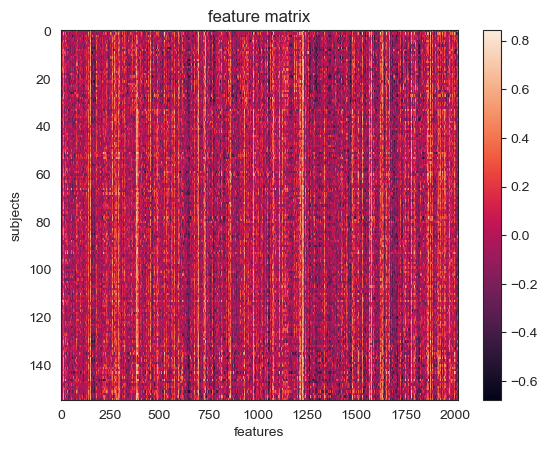

In [28]:
plt.imshow(X_features, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

## Prepare data for machine learning

In [29]:
# Map the classes to numerical labels (0 for "child" and 1 for "adult")
class_mapping = {'child': 0, 'adult': 1}
y_encoded = y.map(class_mapping)

print('y type:',type(y_encoded))
print('X type:',type(X_features))


y type: <class 'pandas.core.series.Series'>
X type: <class 'numpy.ndarray'>


In [31]:
from sklearn.model_selection import train_test_split

# Split the sample into training/test, stratify by age class, and shuffle the data
X_train, X_test, y_train, y_test = train_test_split(
    X_features,  # X 
    y_encoded,  # y 
    test_size=0.2,  # 80%/20% split
    shuffle=True,  # shuffle dataset before splitting
    stratify=y,  # keep distribution of ageclass consistent between train & test sets.
    random_state=123  # same shuffle each time
)

# Print the size of the training and test sets
print('training:', len(X_train), 'testing:', len(X_test))

training: 124 testing: 31


In [32]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training set only
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

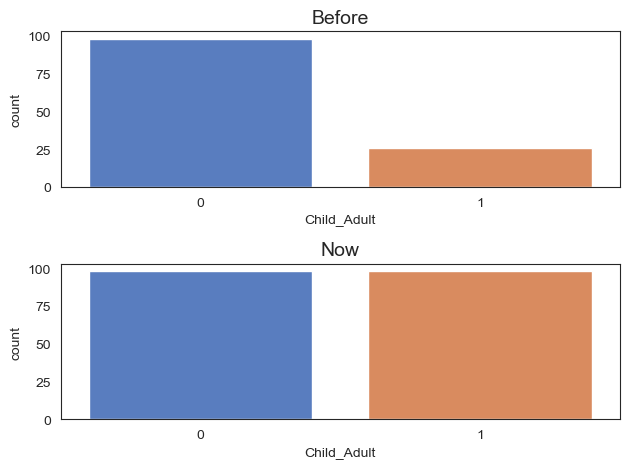

In [34]:
# Check class imbalance
fig,(ax1,ax2) = plt.subplots(2)
sns.countplot(x=y_train, ax=ax1)
ax1.set_title('Before', fontsize=14)
sns.countplot(x=y_train_resampled, ax=ax2)
ax2.set_title('Now', fontsize=14)
plt.tight_layout()


In [50]:
# Check data types 

print('X_train_resampled:',type(X_train_resampled))
print('y_train_resampled:',type(y_train_resampled))
print('X_test:',type(X_test))
print('y_test:',type(y_test))

X_train_resampled: <class 'numpy.ndarray'>
y_train_resampled: <class 'pandas.core.series.Series'>
X_test: <class 'numpy.ndarray'>
y_test: <class 'pandas.core.series.Series'>


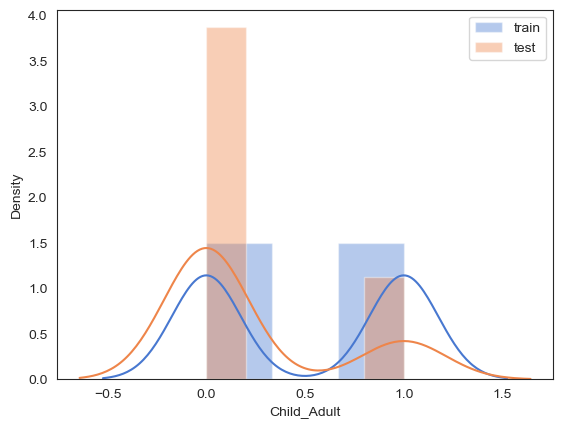

In [49]:
# Check data distribution
sns.distplot(y_train_resampled ,label='train')
sns.distplot(y_test,label='test')
plt.legend();

## Run our model!

We'll start with a standard classification model called a Support Vector Classifier (SVC) 

Despite its simplicity, this model shines in its ability to deliver robust results. Given our data constraints, a straightforward approach often proves to be the most effective.

In [73]:

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define the SVM model with a linear kernel and balanced class weights
svc = SVC(kernel='linear', class_weight='balanced')

# Define a parameter grid for the grid search
param_grid = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient (scale, auto, or a float)
    'degree': [2, 3, 4],         # Degree for polynomial kernel
    'coef0': [0, 1, 2],          # Coefficient for polynomial kernel
    'shrinking': [True, False],  # Whether to use shrinking heuristics
}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to your training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


print(best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'C': 0.1, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'shrinking': True}


In [74]:
# Fit the best estimator to your training data
best_estimator.fit(X_train_resampled, y_train_resampled)

# Make Predictions
y_pred = best_estimator.predict(X_test)


# Evaluate the model

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.9354838709677419
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        24
           1       0.86      0.86      0.86         7

    accuracy                           0.94        31
   macro avg       0.91      0.91      0.91        31
weighted avg       0.94      0.94      0.94        31



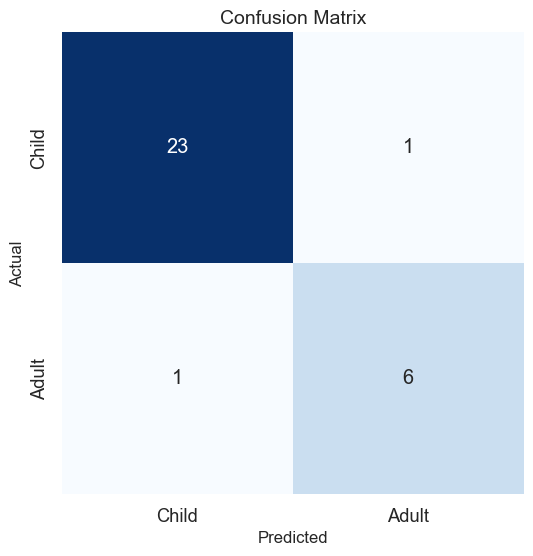

In [75]:
# Compute and plot the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

# Plot a prettier confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for labels
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    square=True,
    xticklabels=['Child', 'Adult'],
    yticklabels=['Child', 'Adult'],
)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()





## Interpreting model feature importance

In [101]:
correlation_measure.inverse_transform(best_estimator.coef_).shape

(1, 64, 64)

Text(0, 0.5, 'weight')

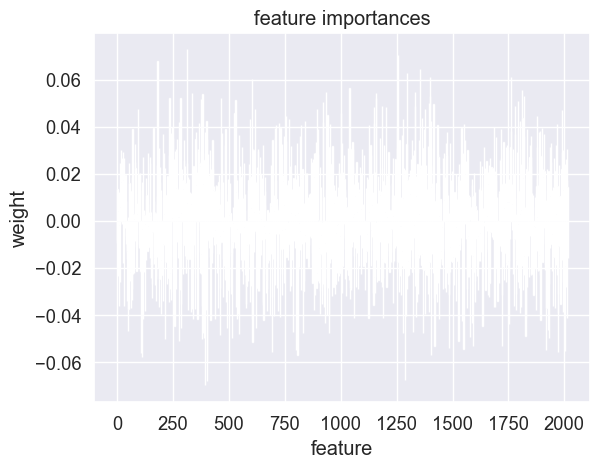

In [85]:
# Get the coefficients (weights) of the linear SVM model from best_estimator
coefficients = best_estimator.coef_


plt.bar(range(coefficients.shape[-1]),coefficients[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

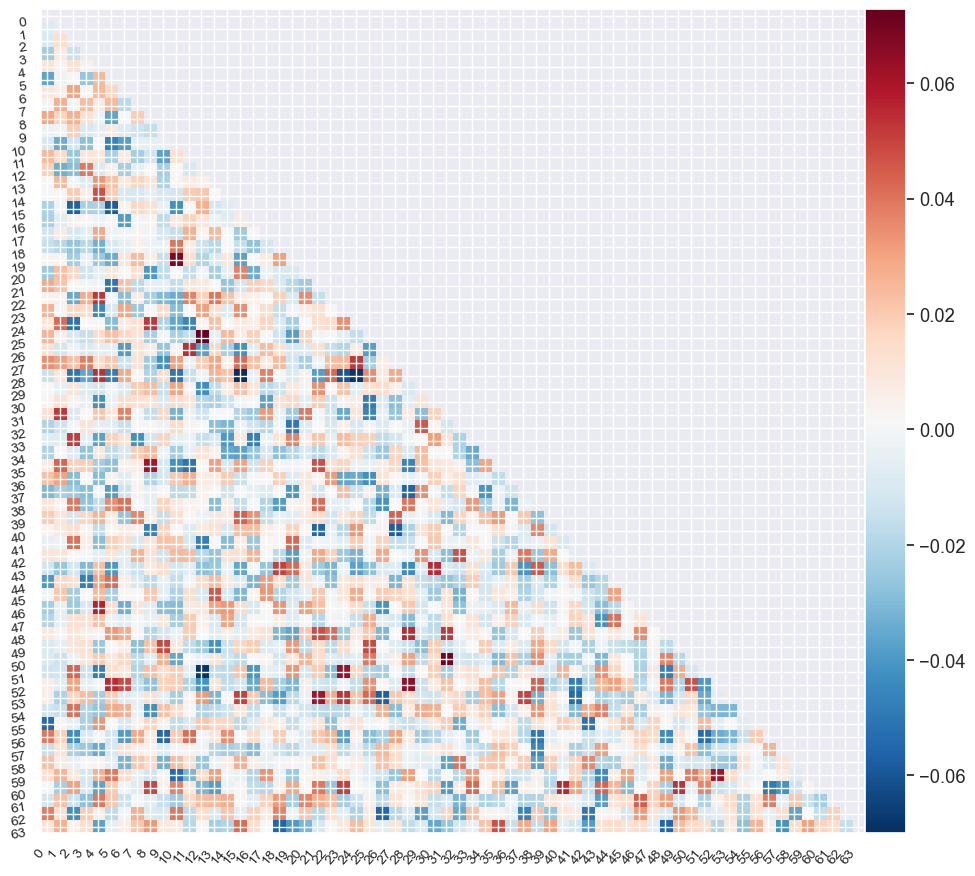

In [102]:

feat_exp_matrix = correlation_measure.inverse_transform(best_estimator.coef_)[0]

plotting.plot_matrix(feat_exp_matrix, figure=(12, 9),  
                     labels=range(feat_exp_matrix.shape[0]),
                     reorder=False,
                    tri='lower');

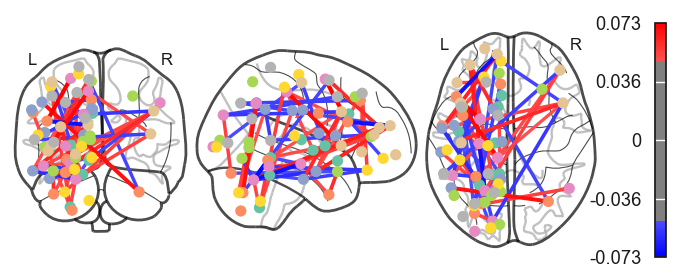

In [108]:
# Create a connectome map where each node is an ROI

coords = plotting.find_parcellation_cut_coords(atlas_filename)

plotting.plot_connectome(feat_exp_matrix, coords, colorbar=True, edge_threshold=0.05)

In [113]:
plotting.view_connectome(feat_exp_matrix, coords, edge_threshold='95%')